In [1]:
infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206''147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36, 147.32.80.9', '147.32.87.11']

In [18]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.preprocessing import StandardScaler as StandardScaler
from helper_functions.classification import *
warnings.filterwarnings("ignore")

In [3]:
names = ['#Date_flow', 'start', 'Durat', 'Prot', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port', 'Flags', 
         'Tos', 'Packets', 'Bytes', 'Flows', 'Label']

df = pd.read_csv('capture20110818.pcap.netflow.labeled', sep ='\s+')
df.head()

,Date,flow,start,Durat,Prot,Src,IP,Addr:Port,Dst,IP.1,Addr:Port.1,Flags,Tos,Packets,Bytes,Flows,Label,Labels
0,2011-08-18,10:19:13.328,0.002,TCP,147.32.86.166:33426,->,212.24.150.110:25443,FRPA_,0,4,321,1,Background,NaN,NaN,NaN,NaN,NaN
1,2011-08-18,10:19:13.328,4.995,UDP,82.39.2.249:41915,->,147.32.84.59:43087,INT,0,617,40095,1,Background,NaN,NaN,NaN,NaN,NaN
2,2011-08-18,10:19:13.329,4.996,UDP,147.32.84.59:43087,->,82.39.2.249:41915,INT,0,1290,1909200,1,Background,NaN,NaN,NaN,NaN,NaN
3,2011-08-18,10:19:13.330,0.000,TCP,147.32.86.166:42020,->,147.32.192.34:993,A_,0,1,66,1,Background,NaN,NaN,NaN,NaN,NaN
4,2011-08-18,10:19:13.330,0.000,TCP,212.24.150.110:25443,->,147.32.86.166:33426,FPA_,0,2,169,1,Background,NaN,NaN,NaN,NaN,NaN


In [4]:
df.drop(labels=['Src', 'Packets', 'Bytes', 'Flows', 'Label', 'Labels'], axis=1, inplace=True)
df.to_csv('./capture20110818.pcap.netflow.labeled.remastered', header=names, index=False)
df.head()

,Date,flow,start,Durat,Prot,IP,Addr:Port,Dst,IP.1,Addr:Port.1,Flags,Tos
0,2011-08-18,10:19:13.328,0.002,TCP,147.32.86.166:33426,212.24.150.110:25443,FRPA_,0,4,321,1,Background
1,2011-08-18,10:19:13.328,4.995,UDP,82.39.2.249:41915,147.32.84.59:43087,INT,0,617,40095,1,Background
2,2011-08-18,10:19:13.329,4.996,UDP,147.32.84.59:43087,82.39.2.249:41915,INT,0,1290,1909200,1,Background
3,2011-08-18,10:19:13.330,0.000,TCP,147.32.86.166:42020,147.32.192.34:993,A_,0,1,66,1,Background
4,2011-08-18,10:19:13.330,0.000,TCP,212.24.150.110:25443,147.32.86.166:33426,FPA_,0,2,169,1,Background


In [19]:
data = pd.read_csv('./capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')
#data['Datetime'] = pd.to_datetime(data['Datetime'], infer_datetime_format=True)

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


In [20]:
# Classification on packet level.
print(len(data[data['Label'] == 'Botnet']))
df_clean = data[ data['Label'] != 'Background']

df_clean.head()

323441


,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
20,4.985,TCP,PA_,0,91,86277,1,LEGITIMATE,147.32.80.13,80,147.32.85.88,56949,2011-08-18 10:19:13.347
51,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.86.110,48102,74.125.232.214,443,2011-08-18 10:19:13.392
57,4.921,TCP,A_,0,49,3234,1,LEGITIMATE,147.32.85.88,56949,147.32.80.13,80,2011-08-18 10:19:13.411
73,4.742,TCP,A_,0,118,7080,1,LEGITIMATE,147.32.84.59,2768,74.125.108.208,80,2011-08-18 10:19:13.460
75,0.000,TCP,A_,0,1,60,1,LEGITIMATE,147.32.84.59,56058,74.125.232.215,443,2011-08-18 10:19:13.486


In [21]:
label_mapping={}
label_mapping['Label'] = {'LEGITIMATE': 0, 'Botnet' : 1}
df_clean.replace({'Label' : label_mapping['Label']}, inplace=True)
y =df_clean['Label'].values
print(y)

[0 0 0 ... 1 0 1]


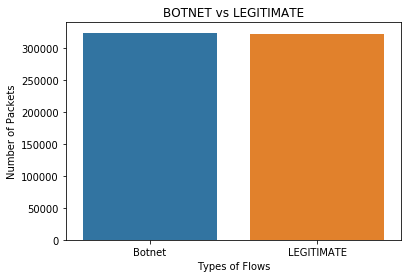

Botnet:  323441
Legitimate:  321917
Ratio:  1.0047341395452865


In [24]:
#Plot that shows imbalance
a = data[ data['Label'] != 'Background']
ax = a['Label'].value_counts()
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x=ax.index, y= ax)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.show()

print("Botnet: ", np.sum(y == 1))
print("Legitimate: ", np.sum(y == 0))
print("Ratio: ", np.sum(y == 1)/np.sum(y == 0))

In [25]:
char_cols = df_clean.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    df_clean[c], label_mapping[c] = pd.factorize(df_clean[c])

In [26]:
X = df_clean.drop(['Label'], axis = 1).values

print("Dataset shape: ", X.shape)

Dataset shape:  (645358, 12)


In [27]:
# 10-Fold stratified cross validation with shuffling of the dataset before extracting the stratified splits,
# used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

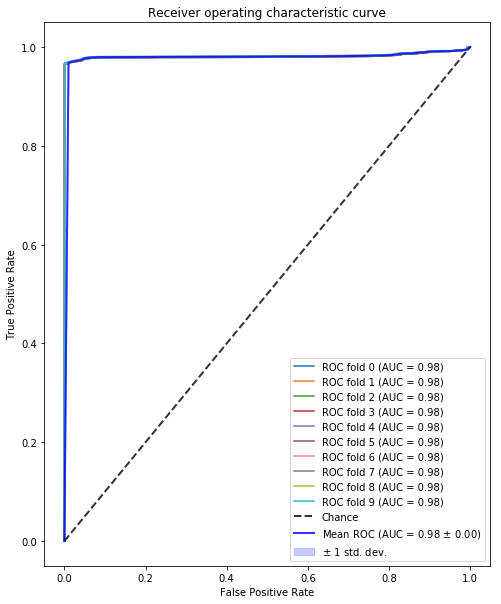

Confusion matrix, without normalization
[[317405   4512]
 [  9897 313544]]


<Figure size 432x288 with 0 Axes>

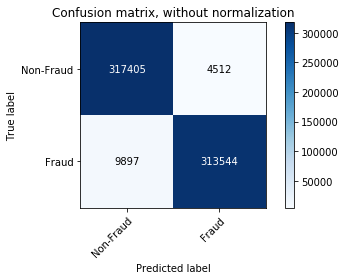

In [15]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

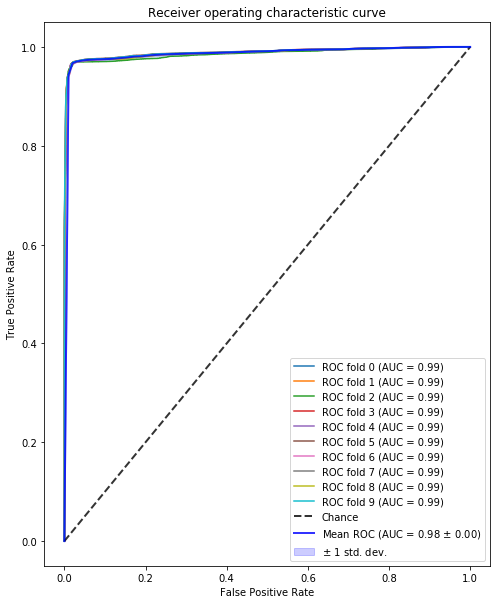

Confusion matrix, without normalization
[[289962  31955]
 [  7991 315450]]


<Figure size 432x288 with 0 Axes>

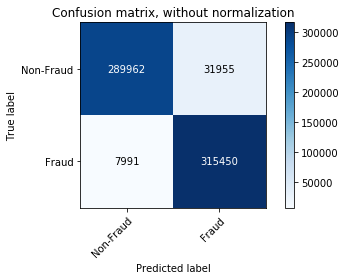

In [16]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
lr_mean_tpr, lr_std_tpr, lr_mean_auc, lr_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)

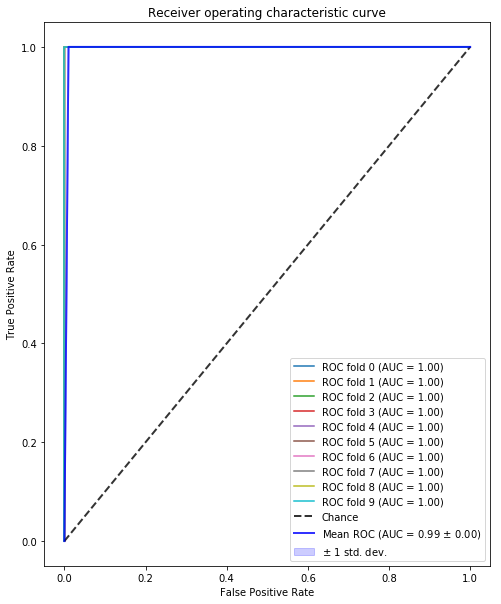

Confusion matrix, without normalization
[[321917      0]
 [    17 323424]]


<Figure size 432x288 with 0 Axes>

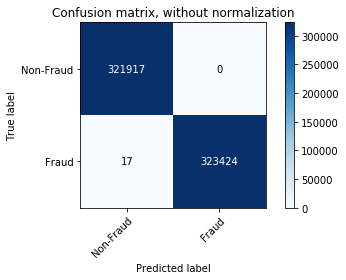

In [28]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
rf_mean_tpr, rf_std_tpr, rf_mean_auc, rf_std_auc, mean_F1, std_F1, cm = roc_analysis(X, y, clf, cv, True, True, True, False)